# **CSE4022: Natural Language Proccessing J Component (Slot:B2)**
## **Project Title:** Automatic Story Generation
### **Team Members:**
1.   Talatala Rahul Reddy  (19BCE1778)
2.   Pulimi Bhargava Reddy (19BCE1342)

#### In this notebook we have trained the Bi-directional GRU Model on multiple short stories

### Importing Libraries & Downloading Dependecies

In [ ]:
#%tensorflow_version 2.x  #selects the tensorflow 2.0+ version
import tensorflow as tf
import string
import requests
import nltk
import bs4
import re
import nltk
nltk.download('punkt')
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Embedding, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Scraping the Short Stories Website http://www.classicshorts.com/ to train the above models

In [ ]:
#return bs4 object
def getPage(url,headers):
    res = requests.get(url, headers=headers)
    try:
        res.raise_for_status()
    except:
        pass
    pageHtml=bs4.BeautifulSoup(res.text,'html.parser')
    return pageHtml

#check if previous scrape already contained the given listing
def getStoryText(link):
    regex = re.compile(r'[\n\r\t]')
    headers = {'User-Agent': 'Mozilla/5.0'}
    pageHtml=getPage(link,headers)
    elems = pageHtml.find_all("div", class_="StoryPara")
    totalText = ""
    for e in elems:
        totalText += regex.sub(" ", e.text.strip())
    return totalText

# Returns an array of dcitionaries - turnip listings
def getListings():
    no_of_stories = 0
    badTitles = {'tlrm','fiddler','frog','ItalianMaster','luck'}
    #f = open("short_stories.txt", "a", encoding='utf-8')
    url = "http://www.classicshorts.com/bib.html"
    headers = {'User-Agent': 'Mozilla/5.0'}
    storyTexts = []
    rawText = ""
    pageHtml=getPage(url,headers)
    elems = pageHtml.find_all("div", class_="biolisting")
    for e in elems:
        currentUrl = "http://www.classicshorts.com/stories/"+e.attrs['onclick'][11:-2]+".html"
        if e.attrs['onclick'][11:-2] not in badTitles:
            pog = getStoryText(currentUrl)
            storyTexts.append(pog)
            no_of_stories = no_of_stories + 1
            #print("No of Stories:"+str(no_of_stories))
            rawText += pog
        if no_of_stories == 100:
            break
        
    #print("Len of story texts:"+str(len(storyTexts)))
    #print("No of stories:"+str(no_of_stories))
    #print(storyTexts)
    #f.write(rawText)
    #f.close()
    return rawText

In [ ]:
#fetching the short stories by scraping
stories = getListings()
stories = stories[81:]
len(stories)

1983654

### Sentence Tokenising the short-stories

In [ ]:
#performing sentence tokenisation
from nltk.tokenize import sent_tokenize
sentences = sent_tokenize(stories)
len(sentences)

20516

In [ ]:
#displays first 3 sentences
sentences[:3]

['My Dear Sir: I am happy to assure you that your anxiety is without reason.',
 'Flemming will be confined to the sofa for three or four weeks, and will have to be careful at first how he uses his leg.',
 'A fracture of this kind is always a tedious affair.']

### Tokenising the short stories and cleaning the data

In [ ]:
#cleaning the dataset
def clean_text(sentences):
    #creating tokens from the document
    tokens = []
    for sentence in sentences:
      tokens.extend(nltk.word_tokenize(sentence))
    punc = str.maketrans('','',string.punctuation)
    #this list will remove punctuations
    tokens = [ x.translate(punc) for x in tokens]
    #this list will remove special characters
    tokens = [ x for x in tokens if x.isalpha()]
    #this list converts all the words to lowercase
    tokens = [ x.lower() for x in tokens]
    return tokens

In [ ]:
tokens = clean_text(sentences)

In [ ]:
tokens[:10]

['my', 'dear', 'sir', 'i', 'am', 'happy', 'to', 'assure', 'you', 'that']

In [ ]:
len(tokens) #no of tokens in the 100 short stories

364182

In [ ]:
len(set(tokens)) #no of unique words in the 100 short stories

21957

### Generating sequence of tokens

In [ ]:
#creating the sequence of tokens
length = 50 + 1 #first 50 words as input and 1 as the output
lines = []

for i in range(length,len(tokens)):
    seq = tokens[i-length:i]
    line = ' '.join(seq)
    lines.append(line)
    if i > 110000: #we're only taking few tokens as input for the model
        break

In [ ]:
len(lines)

109951

In [ ]:
lines[:4]

['my dear sir i am happy to assure you that your anxiety is without reason flemming will be confined to the sofa for three or four weeks and will have to be careful at first how he uses his leg a fracture of this kind is always a tedious affair fortunately',
 'dear sir i am happy to assure you that your anxiety is without reason flemming will be confined to the sofa for three or four weeks and will have to be careful at first how he uses his leg a fracture of this kind is always a tedious affair fortunately the',
 'sir i am happy to assure you that your anxiety is without reason flemming will be confined to the sofa for three or four weeks and will have to be careful at first how he uses his leg a fracture of this kind is always a tedious affair fortunately the bone',
 'i am happy to assure you that your anxiety is without reason flemming will be confined to the sofa for three or four weeks and will have to be careful at first how he uses his leg a fracture of this kind is always a ted

### Converting tokens to numerical values

In [ ]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(lines) 
#performing tokenisation on the seq of words (lines) and these seq of words are embedded as integers basically word embedding
#every unique token(word) is given an integer as ML model only works on numerical values
sequences = tokenizer.texts_to_sequences(lines)

In [ ]:
tokenizer.word_index 

{'the': 1,
 'and': 2,
 'of': 3,
 'a': 4,
 'to': 5,
 'he': 6,
 'in': 7,
 'was': 8,
 'i': 9,
 'his': 10,
 'it': 11,
 'that': 12,
 'had': 13,
 'with': 14,
 'you': 15,
 'she': 16,
 'on': 17,
 'at': 18,
 'her': 19,
 'as': 20,
 's': 21,
 'for': 22,
 'him': 23,
 'not': 24,
 'but': 25,
 'is': 26,
 'they': 27,
 'from': 28,
 'were': 29,
 'my': 30,
 'said': 31,
 'there': 32,
 'be': 33,
 'all': 34,
 'by': 35,
 'one': 36,
 'have': 37,
 'me': 38,
 'would': 39,
 'nt': 40,
 'an': 41,
 'no': 42,
 'out': 43,
 'up': 44,
 'this': 45,
 'which': 46,
 'what': 47,
 'when': 48,
 'man': 49,
 'we': 50,
 'so': 51,
 'do': 52,
 'them': 53,
 'then': 54,
 'into': 55,
 'or': 56,
 'their': 57,
 'could': 58,
 'now': 59,
 'if': 60,
 'been': 61,
 'like': 62,
 'are': 63,
 'did': 64,
 'about': 65,
 'down': 66,
 'who': 67,
 'your': 68,
 'some': 69,
 'little': 70,
 'over': 71,
 'only': 72,
 'will': 73,
 'eyes': 74,
 'time': 75,
 'more': 76,
 'old': 77,
 'very': 78,
 'back': 79,
 'made': 80,
 'come': 81,
 'again': 82,
 'know':

In [ ]:
sequences = np.array(sequences)

In [ ]:
sequences[:2]
#it is a 2d array
#rows represent the line of the short stories
#column represent the words (there are 51 cols)

array([[   30,   309,   846,     9,    97,   567,     5,  1890,    15,
           12,    68,  3705,    26,   132,   524,   702,    73,    33,
        11636,     5,     1,  2266,    22,   188,    56,   300,   969,
            2,    73,    37,     5,    33,  5505,    18,   102,   103,
            6, 11633,    10,   371,     4, 11630,     3,    45,   318,
           26,   177,     4,  5504,  3703,  2805],
       [  309,   846,     9,    97,   567,     5,  1890,    15,    12,
           68,  3705,    26,   132,   524,   702,    73,    33, 11636,
            5,     1,  2266,    22,   188,    56,   300,   969,     2,
           73,    37,     5,    33,  5505,    18,   102,   103,     6,
        11633,    10,   371,     4, 11630,     3,    45,   318,    26,
          177,     4,  5504,  3703,  2805,     1]])

In [ ]:
sequences.shape #51 cols are words where we take first 50 cols(words) as x and last col(word) as y

(109951, 51)

### Preparing data to that has to fed into the model

In [ ]:
#first 50 tokens(words) are x and last tokens is y
X,y = sequences[:,:-1] , sequences[:,-1]
#sequences[:,-1] selects only the last col
#sequences[:,:-1] selects all cols except the last col

In [ ]:
X[:2]

array([[   30,   309,   846,     9,    97,   567,     5,  1890,    15,
           12,    68,  3705,    26,   132,   524,   702,    73,    33,
        11636,     5,     1,  2266,    22,   188,    56,   300,   969,
            2,    73,    37,     5,    33,  5505,    18,   102,   103,
            6, 11633,    10,   371,     4, 11630,     3,    45,   318,
           26,   177,     4,  5504,  3703],
       [  309,   846,     9,    97,   567,     5,  1890,    15,    12,
           68,  3705,    26,   132,   524,   702,    73,    33, 11636,
            5,     1,  2266,    22,   188,    56,   300,   969,     2,
           73,    37,     5,    33,  5505,    18,   102,   103,     6,
        11633,    10,   371,     4, 11630,     3,    45,   318,    26,
          177,     4,  5504,  3703,  2805]])

In [ ]:
y[:2]

array([2805,    1])

In [ ]:
vocabulary_size = len(tokenizer.word_index) + 1 #1 as it's stating from 1 (that word_index is from 1)
vocabulary_size

11638

In [ ]:
y = to_categorical(y,num_classes=vocabulary_size)
# a numpy array/vector which has integers that represent different categories is converted into a numpy array/matrix 
#which has binary values and has columns equal to the number of categories in the data.
#X.shape[1] is 50
seq_length = X.shape[1]

### Creating a function to generate stories from a given seed text

In [ ]:
def generate_story(model,tokenizer,text_seq_len,seed_text,n_words):
  text = []
  for _ in range(n_words):
    encoded = tokenizer.texts_to_sequences([seed_text])[0]
    #the model expects the input(sentences) to be of same length hence we use the pad_sequences
    #pre it adds 0 before the sentence
    encoded = pad_sequences([encoded],maxlen=text_seq_len,padding='pre')

    pred = model.predict(encoded) 
    y_pred = np.argmax(pred,axis=1)
    predicted_word = ''
    for word,index in tokenizer.word_index.items():
      if index == y_pred:
        predicted_word = word
        break
    seed_text = seed_text + ' ' + predicted_word
    text.append(predicted_word)
  return ' '.join(text)

### Training the Bi-directional GRU Model

In [ ]:
bi_di_gru = Sequential()
#input layer
bi_di_gru.add(Embedding(vocabulary_size,50,input_length=seq_length))
#hidden layer 1 (LSTM layer)
bi_di_gru.add(Bidirectional(GRU(100,return_sequences=True)))
bi_di_gru.add(Dropout(0.2))
#hidden layer 2 (LSTM layer)
bi_di_gru.add(GRU(120))
#hidden layer 3 (dense layer)
bi_di_gru.add(Dense(140,activation='relu'))
#output layer
bi_di_gru.add(Dense(vocabulary_size,activation='softmax'))#units=vocab size bcoz we want probability for each predicted word

In [ ]:
bi_di_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            581900    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          91200     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 200)           0         
                                                                 
 gru_1 (GRU)                 (None, 120)               115920    
                                                                 
 dense (Dense)               (None, 140)               16940     
                                                                 
 dense_1 (Dense)             (None, 11638)             1640958   
                                                        

In [ ]:
bi_di_gru.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
bidi_gru_history = bi_di_gru.fit(X,y,batch_size=256,epochs=150)

Epoch 1/150
430/430 [==============================] - 36s 68ms/step - loss: 6.9204 - accuracy: 0.0636
Epoch 2/150
430/430 [==============================] - 29s 67ms/step - loss: 6.3982 - accuracy: 0.0801
Epoch 3/150
430/430 [==============================] - 29s 67ms/step - loss: 6.0772 - accuracy: 0.0997
Epoch 4/150
430/430 [==============================] - 29s 68ms/step - loss: 5.8242 - accuracy: 0.1168
Epoch 5/150
430/430 [==============================] - 29s 68ms/step - loss: 5.6297 - accuracy: 0.1285
Epoch 6/150
430/430 [==============================] - 29s 67ms/step - loss: 5.4616 - accuracy: 0.1364
Epoch 7/150
430/430 [==============================] - 29s 67ms/step - loss: 5.3014 - accuracy: 0.1445
Epoch 8/150
430/430 [==============================] - 29s 68ms/step - loss: 5.1444 - accuracy: 0.1519
Epoch 9/150
430/430 [==============================] - 29s 68ms/step - loss: 4.9924 - accuracy: 0.1589
Epoch 10/150
430/430 [==============================] - 29s 68ms/step - l

In [ ]:
bi_di_gru.save('./Bi_di_GRU.h5')

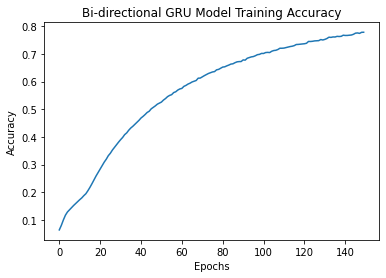

In [ ]:
import matplotlib.pyplot as plt
epochs = range(len(bidi_gru_history.history['accuracy']))
plt.plot(epochs,bidi_gru_history.history['accuracy'])
plt.title("Bi-directional GRU Model Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.show()

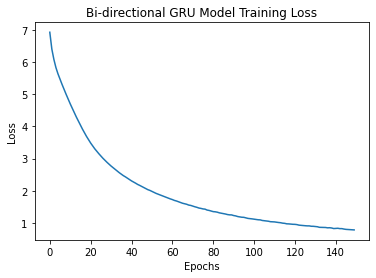

In [ ]:
plt.plot(epochs,bidi_gru_history.history['loss'])
plt.title("Bi-directional GRU Model Training Loss")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.show()

### Generating Stories from Bi-directional GRU Model

In [ ]:
seed_text = "The country was in chaos but"
generate_story(bi_di_gru, tokenizer, seq_length, seed_text, 50) #generate next 50 words

'they had helped they were back for a mask when he remembered was the child to it had a small patch of congealed blood and the dead s company was letting him midnight the piano on a federal photographer and were out of sorts and social kingdoms your books have'

In [ ]:
seed_text = "I walked out of the store dissatisfied and it"
generate_story(bi_di_gru, tokenizer, seq_length, seed_text, 50) #generate next 50 words

'had been devoured grave he cried that he had lost within the character which was three years he could hear johnny called up and with tears and then he dozed offone day when it was like a midshipman and walked in the island of the fort and a piece of'

In [ ]:
seed_text = "The lady was known as a soothsayer - a psychic of sorts. The rubbing of her crystal ball was finalized as she completed her prophecy. Her hands were wrinkled and dirty, a strange companion to the polish of the ball she held in her hands."
generate_story(bi_di_gru, tokenizer, seq_length, seed_text, 50) #generate next 50 words

'on every year and that afternoon or until no doubt leapt from my own determination for off de american boy held his champagne he must cook it hundreds of times but i did not know anything he announced gleefully then remembering the family insisted that he and admiral remain behindit'

In [ ]:
seed_text = "Little Chandler's thoughts ever since lunch-time had been of his meeting with Gallaher, of Gallaher's invitation, and of the great city London where Gallaher lived. He was called Little Chandler because"
generate_story(bi_di_gru, tokenizer, seq_length, seed_text, 100) #generate next 100 words

'of course we were s means in melancholy in deep and it turned the cliff and his hair was still more as though it were the elder by a matter of minutes and then they were conscious of a small family but no nightlight to make a blessed breach no i ll get up he said somewhat all right we re feeling whom he wondered if he had ever been remembered of course i spoke in a muffled whisper and no doubt flemming these stories oh henry daw was free to see he said he thought malignantly i thought about'

In [ ]:
seed_text = "On the morning of the fifth of September, in uniform, his revolver on the table, the colonel addressed his soliders and"
generate_story(bi_di_gru, tokenizer, seq_length, seed_text, 100) #generate next 100 words

'stand quite still more than a baron she proffered no explanation his silence was irritating and made her own plans and myself are haunting me for now that all the first time about whose ferocity was rendered gentle which it was late to be he did not go home in the drama that one could derive true enjoyment and become cultivated and humane but do you suppose the public understands that she used to say what they want to know what i was asked he remarked somewhat later ef i was asked expectations i thought he d throw over some'

In [ ]:
seed_text = "On Christmas Eve around 1978, when I was a young boy, after having the traditional pastry and cookies and after having sung around the fire, I, with my sister, my mother and my aunts, and Emma Jackman and her son, got into Emma Jackman's car and then later"
generate_story(bi_di_gru, tokenizer, seq_length, seed_text, 100) #generate next 100 words

'ivan dmitritch thought was little few showing me proffered a poor window the things of silence the band of a small smug town coming to him as if what also could be set advantage of the middle of the big manufacturers of the while and you know but there briefly no longer clearly reply when the commander s men out of human human mother are impossible for me came and s pause i know the incident of the sturgeon marfa went up to the mogilev wilderness he s only a confirmed place of his regiment and i learned this and'